# First-Year Writing Seminars

### Introduction
If you recall pre-enroll, there was a separate ballot you completed by listing your top 5 picks for FWS that semester. You were then later notified which class you got placed into, probably hoping it was your first choice. By now, this should not seem like magic; problems like these often enlist help from Operations Research especially as the scale increases. Disclaimer: the following model is not actually used by Cornell.

### Import the following

In [1]:
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR

## Part 1: Brainstorming

### Questions
- How can FWS sections be assigned so that the most number of students get one of their top 5 picks?
- How can we improve the assignments?

We want to *assign* a class to each student. This sounds like an assignment problem, which is a special case of the *transportation problem*.  

**Example 1**  
The following table gives an instance with 7 students (1-7) and 4 classes (A-D). Each class has a capacity of 2 students. 

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   D   |    C   |
|    3    |   A   |    C   |
|    4    |   B   |    D   |
|    5    |   C   |    B   |
|    6    |   A   |    B   |
|    7    |   B   |    A   |

**Q:** What are the supply nodes?  
**A:** <font color='blue'>Students</font>  

**Q:** What are the supply values of the supply nodes? <font color='grey'>(Hint: How many units can be transferred?)</font>  
**A:** <font color='blue'>1</font>  

**Q:** What are the demand nodes?  
**A:** <font color='blue'>Classes</font>  

**Q:** What are the demand values of the demand nodes? <font color='grey'>(Hint: How many units can be received?)</font>  
**A:** <font color='blue'>Capacity which in this case is 2</font>  

**Q:** What does a directed edge from a supply node to a demand node mean?  
**A:** <font color='blue'>The student is assigned to that class</font>  

**Q:** What are the edge costs?  
**A:** <font color='blue'>1 for student to first and 2 for student to second (minimize cost)</font>

Visualize your graph by adding the specific supply nodes to list S and demand nodes to list D. If you use letters as node names, make sure to put quotes around them. E is a dictionary of edges and their costs. For example, S = [1,2] and E = {(1,'A'):1}.

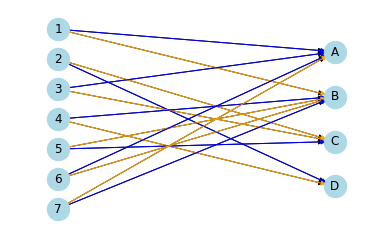

In [2]:
from fws_lab import ex1

S = [1,2,3,4,5,6,7]
D = ['A','B','C','D']
E = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, (4,'B'):1, (4,'D'):2, 
     (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, (7,'B'):1, (7,'A'):2}

ex1(S, D, E)

To complete the simple model, we need to answer one more question.  

**Q:** The total demand is 8, but the current total supply is only 7. How can we make sure that demand is satisfied for there to be a feasible solution?  
**A:** <font color='blue'>Add a dummy node and edges going from it to every class node with cost 3</font>  


Update the lists and dictionary below as see fit.

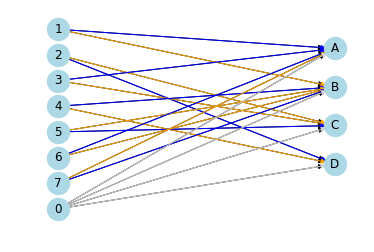

In [3]:
SS = [1,2,3,4,5,6,7,0]
EE = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, (4,'B'):1, (4,'D'):2, 
      (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, (7,'B'):1, (7,'A'):2, (0,'A'):3, (0,'B'):3, (0,'C'):3, (0,'D'):3}

ex1(SS, D, EE)

## Part 2: Solving

Write a LP to solve the FWS assignment problem.

In [4]:
# a model for assigning fws
# 'students' is a list, 'edges' is a dictionary of edges:cost, 'csize' is class capacity, 'dcost' is dummy edge cost
def Assign(students,edges,csize,dcost,solver):
    STUDENT = [] 
    STUDENT.extend(students)
    STUDENT.append(0)             # add dummy node within function
    CLASS = []                    # create class list within function
    EDGES = list(edges.keys())
    for edge in EDGES:
        if not edge[1] in CLASS:
            CLASS.append(edge[1])
    newedges = list(itertools.product([0], CLASS))
    EDGES.extend(newedges)        # add dummy edges
    c = edges.copy()              # c[i,j] = cost
    for edge in newedges:
        c.update({edge : dcost})  # add dummy edge costs
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # decision variables
    x = {} # student i in class j is 1, else 0 except for edges from the dummy node which can take any integer value
    for i,j in EDGES:
        x[i,j] = m.IntVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
        
    # objective function
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
        
    # subject to: does not exceed supply (2 constraints)
    for k in students:
        m.Add(sum(x[i,j] for i,j in EDGES if i==k) <= 1)
    
    m.Add(sum(x[0,j] for j in CLASS) <= len(CLASS)*csize)
        
    # subject to: meets demand
    for k in CLASS:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) == csize)

    m.Solve()
    
    unmatched = []
    for k in STUDENT:
        if (sum(x[i,j].solution_value() for i,j in EDGES if i==k) == 0) and (k!=0):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in EDGES:
        if x[i,j].solution_value() == 1:
            if c[i,j] in matched:
                matched[c[i,j]] += 1
            else:
                matched.update({c[i,j] : 1})
    if dcost in matched.keys():
        del matched[dcost]
    
    return matched

In [5]:
# replace ??? with cost of edges from dummy node
sol1 = Assign(S, E, 2, 3, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol1)

Unmatched students: 0
{1: 6, 2: 1}


6 students got their first choice, 1 student got their second choice, and no students were left unmatched.   

**Q:** Why can't all the students be assigned their first choice? Or do you think the answer you got could be better?  
**A:** <font color='blue'>Limited capacity of classes</font> 

**Example 2**  
In this new instance with 8 students (1-8) and 4 classes (A-D), more students prefer A and B than C and D:  

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   B   |    A   |
|    3    |   C   |    D   |
|    4    |   A   |    B   |
|    5    |   B   |    A   |
|    6    |   A   |    C   |
|    7    |   C   |    D   |
|    8    |   A   |    D   |

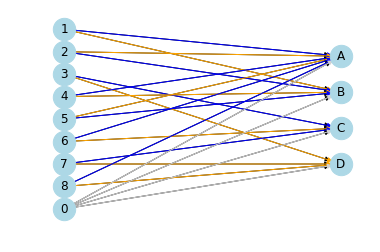

In [6]:
from fws_lab import ex2

S2 = [1,2,3,4,5,6,7,8]
E2 = {(1,'A'):1, (1,'B'):2, (2,'B'):1, (2,'A'):2, (3,'C'):1, (3,'D'):2, (4,'A'):1, (4,'B'):2, 
      (5,'B'):1, (5,'A'):2, (6,'A'):1, (6,'C'):2, (7,'C'):1, (7,'D'):2, (8,'A'):1, (8,'D'):2}

ex2(S2, E2)

In [7]:
# cost of edges from dummy node is 2.5
sol2 = Assign(S2, E2, 2, 2.5, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol2)

Unmatched students: 1
{1: 6, 2: 1}


There is 1 unmatched student when using 2.5 as the cost of dummy edges.  

**Q:** Why can't all the students be assigned one of their top 2 choices? Or do you think the answer you got could be better?  
**A:** <font color='blue'>Can find a 0 unmatched assignment</font>  

Re-solve using 3 as the cost.

In [8]:
# cost of edges from dummy node is 3
sol3 = Assign(S2, E2, 2, 3, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol3)

Unmatched students: 0
{1: 5, 2: 3}


**Q:** 2.5 and 3 are both greater than 1 and 2 and prioritized last. What then is causing the different solutions?  
**A:** <font color='blue'>The combined cost of a first pick edge and a dummy edge versus two second pick edges: $1+2.5 < 2+2$ while $1+3 = 2+2$ </font>  

When solving the actual data, you will see that other subtle reasons might lead to unmatched students.

## Part 3: Solving the Actual Data

There are 2886 students and 183 class sections. Assume each class can have at most 16 students. As we already know, each student picks their top 5 classes.

In [9]:
# read in the dataset
data = pd.read_csv('Fall2009Ballots.csv')
data.head()    # preview

,STUDENTS,1,2,3,4,5
0,1,145,142,125,143,80
1,2,72,12,149,171,8
2,3,79,87,37,120,97
3,4,104,101,103,100,99
4,5,26,154,149,101,28


There are 6 columns with the first being student # and the other 5 being first, second, third, fourth, and fifth choice. Each row is a student, and class # indicates the class picked as the choice belonging to the column.  

The dataset has been transformed behind the scenes from what you see above into the correct formats for the inputs. Nothing has changed about the model except the edge costs are equal to the choice rank (1-5) and the edges from the dummy node have a cost of 6.

In [10]:
from fws_lab import inputData
students,edges = inputData('Fall2009Ballots.csv')

data_sol = Assign(students, edges, 16, 6, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(data_sol)

Unmatched students: 85
{1: 1638, 4: 152, 2: 627, 3: 341, 5: 43}


We got an answer! Unfortunately, there are 85 students who did not get any of their top 5 picks. Let's try to make our model better, so that no students are unmatched.  

The objective function is actually a weighted function. The coefficients, which in this case are the costs, dictate how much you want the solver to select the corresponding edges. An edge with a small cost has a higher likelihood (weight) of being in the solution while an edge with a large cost will potentially be avoided. This being said, we can try setting the cost of edges from the dummy node to an arbitrarily large number like 100,000. This should create greater incentive to fill classes with actual students than our fake filler 'students' as we witnessed in the second small example.

In [11]:
data_sol2 = Assign(students, edges, 16, 100000, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(data_sol2)

Unmatched students: 0
{1: 1528, 4: 207, 2: 676, 3: 388, 5: 87}


Yay! We just improved our model. As a bonus, we can look at the distribution of preferences received by students in the form of a histogram and see how our solution did in percentages.

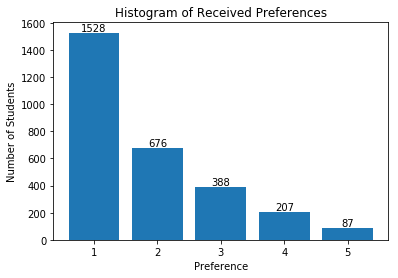

1 : 52.95 %
4 : 7.17 %
2 : 23.42 %
3 : 13.44 %
5 : 3.01 %


In [12]:
from fws_lab import Histo
Histo(data_sol2, 15)

for pref in data_sol2.keys():
    print(pref, ":", round(100*data_sol2[pref]/2886, 2), "%")

## Challenge 1

We do not want to waste time trying different cost combinations if there is no solution where every student gets one of their top 5 picks. How can we check whether there exists a feasible solution with 0 unmatched students?  

**Q:** What is the cost of edges representing students' preferences?  
**A:** <font color='blue'>0</font>  

**Q:** What is the cost of dummy edges?  
**A:** <font color='blue'>1</font>  

**Q:** What is the desired solution?  
**A:** <font color='blue'>Zero cost assignment</font>  

-- OR --  
**Q:** Describe another way that might use a different model.  
**A:** <font color='blue'>e.g. max flow</font>  

## Challenge 2

There are many ways to improve a model even if the type of problem does not change. Previously, we decided it was important for an assignment to guarantee that everyone got at least one of their top 5 picks. How can you make a better yet model? <font color='grey'>(Your answer will depend on what you think makes the best assignment. Some things to consider: reducing the number of students getting their lesser-preferred choices, adding a lower bound on class size, choosing for two students to both have their 3rd choice instead of one 1st and the other 5th, using recursion...)</font>